In [1]:
# Load Libraries & Models
import cv2
import numpy as np
import joblib
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from skimage.feature import hog  # Import HOG

# Load YOLO model for bud detection
bud_detection_model_path = "best.pt"
bud_detection_model = YOLO(bud_detection_model_path)

# Load Random Forest model for variety classification
rf_model = joblib.load("sugarcane_rf_model.pkl")

# Define Image Processing Settings
IMG_SIZE = (128, 128)  # Resize images

In [2]:
# Show Image Function
def show_image(image, title="Image"):
    """
    Displays an image using Matplotlib.
    """
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


In [3]:
# Bud Detection & Cropping
def detect_and_crop_bud(image_path):
    """
    Detects the bud in the image using YOLO and crops it.
    """
    img = cv2.imread(image_path)

    # Show Original Image
    show_image(img, "Original Image")

    results = bud_detection_model(img)  # Run YOLO inference
    boxes = results[0].boxes.xyxy  # Extract bounding boxes

    if len(boxes) == 0:
        print("❌ No bud detected!")
        return None

    # Extract bounding box coordinates (first detected bud)
    x1, y1, x2, y2 = map(int, boxes[0])  # Get first detected bud
    cropped_bud = img[y1:y2, x1:x2]  # Crop the detected bud

    # Show Cropped Bud
    show_image(cropped_bud, "Detected Bud")

    return cropped_bud  # Return cropped image

In [4]:
# Feature Extraction
def extract_features(img):
    """
    Extracts features from an image (color histograms + HOG).
    """
    img = cv2.resize(img, IMG_SIZE)  # Resize
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    # Histogram Features (Color Distribution)
    hist_r = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([img], [2], None, [256], [0, 256])
    
    hist_features = np.concatenate((hist_r.flatten(), hist_g.flatten(), hist_b.flatten()))

    # HOG Feature Extraction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8), 
                       cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

    # Combine HOG + Histogram features
    combined_features = np.concatenate((hist_features, hog_features))

    return combined_features  # New feature vector

In [5]:
# Mapping variety numbers to names
VARIETY_NAMES = {
    1: "Common",
    2: "SL 03 336",
    3: "SL 03 1077",
    4: "SL 03 1188"
}

# Predict Sugarcane Variety
def predict_sugarcane_variety(image_path):
    """
    Detects the bud, extracts features, and predicts the variety.
    """
    cropped_bud = detect_and_crop_bud(image_path)

    if cropped_bud is None:
        return None  # Exit if no bud detected

    # Extract features
    features = extract_features(cropped_bud)
    features = features.reshape(1, -1)  # Reshape for prediction

    # Predict the class
    predicted_class = rf_model.predict(features)[0] + 1  # Convert to 1-based index

    # Get variety name
    variety_name = VARIETY_NAMES.get(predicted_class, "Unknown Variety")

    # Print prediction
    print(f"✅ Predicted Sugarcane Variety: {variety_name}")


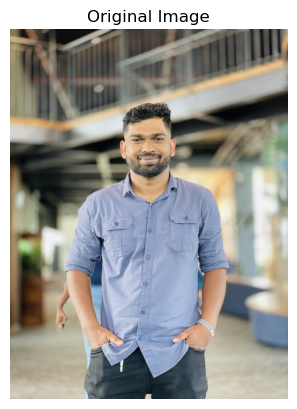


0: 640x480 (no detections), 250.1ms
Speed: 22.6ms preprocess, 250.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)
❌ No bud detected!


In [8]:
# Test the pipeline
image_path = "testImage.jpg"  # Change this to your test image path
predict_sugarcane_variety(image_path)